In [10]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 24,14


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.<br>
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.<br>
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.<br>
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.
<br><br>
The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.<br>
d: The number of times that the raw observations are differenced, also called the degree of differencing.<br>
q: The size of the moving average window, also called the order of moving average.<br>

In [2]:
covid = pd.read_csv('/Users/satyamgovila/Desktop/Work/covid/raw_covid.csv')

In [3]:
covid = covid[31:]

In [4]:
covid.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
31,01 March,0,3,0,3,0,0
32,02 March,2,5,0,3,0,0
33,03 March,1,6,0,3,0,0
34,04 March,22,28,0,3,0,0
35,05 March,2,30,0,3,0,0


In [5]:
covid_data = covid[['Date' , 'Total Confirmed']]
covid_data['date_format'] = pd.date_range(start='03/1/2020', periods=len(covid_data), freq='D')
cols = covid_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
covid_data = covid_data[cols] 
covid_data['date_format'] = pd.to_datetime(covid_data['date_format'], infer_datetime_format=True)

/Users/satyamgovila/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
covid_data.tail()

,date_format,Date,Total Confirmed
74,2020-04-13,13 April,10455
75,2020-04-14,14 April,11490
76,2020-04-15,15 April,12372
77,2020-04-16,16 April,13434
78,2020-04-17,17 April,14354


In [7]:
covid_data = covid_data[['date_format' , 'Total Confirmed']]
indexedDataset = covid_data.set_index(['date_format'])

In [8]:
indexedDataset.head()

,Total Confirmed
date_format,
2020-03-01,3
2020-03-02,5
2020-03-03,6
2020-03-04,28
2020-03-05,30


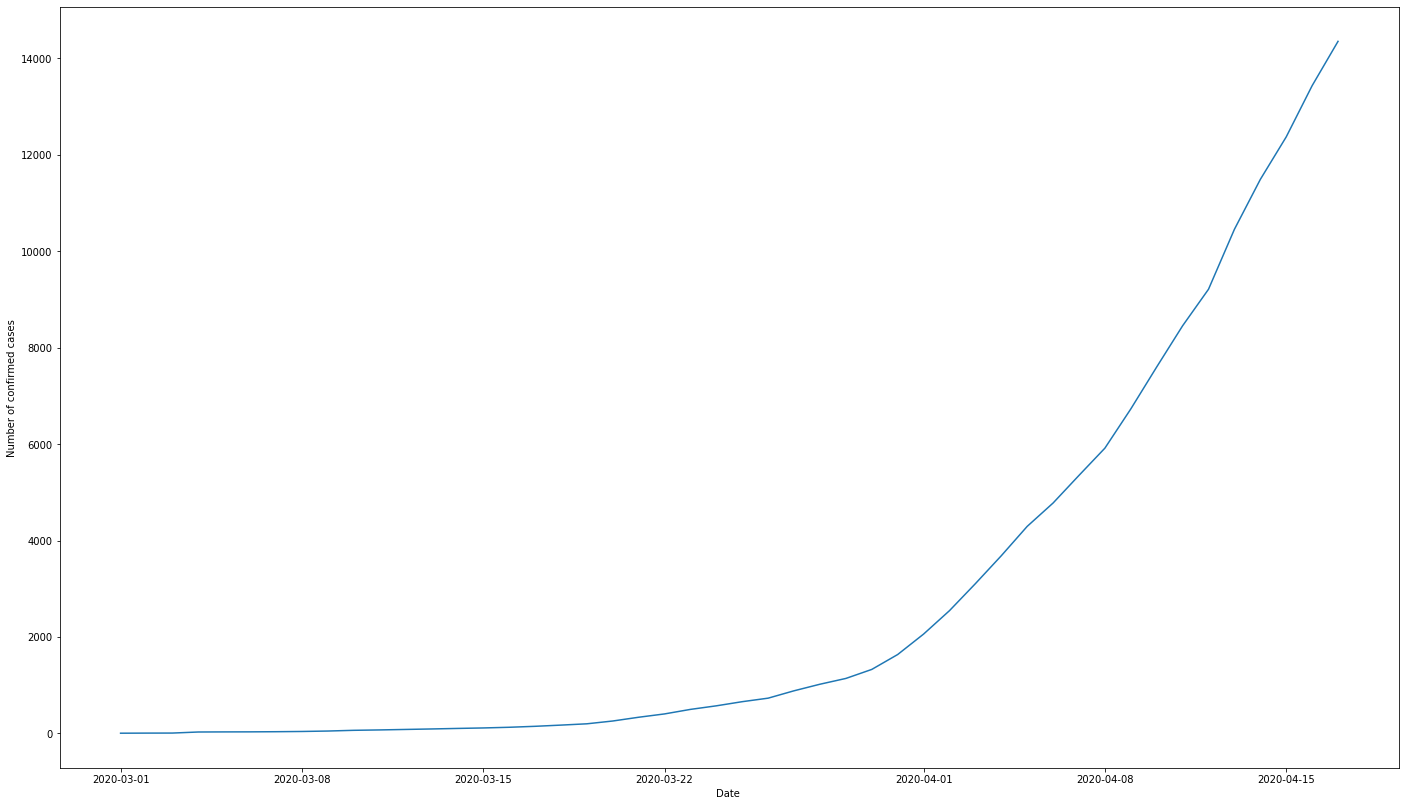

In [11]:
plt.xlabel('Date ')
plt.ylabel('Number of confirmed cases')
plt.plot(indexedDataset)

To build **ARIMA model**, we must ensure that the time series is stationary.<br>There are two primary way to determine whether a given time series is stationary.<br>
(1.)**Rolling Statistics**:<br>
Plot the rolling mean and rolling standard deviation.<br>
The time series is stationary if they remain constant with time.(Lines should be parallel to x-axis)<br>
(2.)**Augmented Dickey-Fuller Test**:<br>
The time series is considered stationary -  if the p-value is low , and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics
Augumented D-F test: <br>
1.  Cirical values should be greater than ADF Statistic 
2.  p-value less than equal to 0.05

In [12]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)


             Total Confirmed
date_format                 
2020-03-01               NaN
2020-03-02               NaN
2020-03-03               NaN
2020-03-04               NaN
2020-03-05               NaN
2020-03-06               NaN
2020-03-07               NaN
2020-03-08               NaN
2020-03-09               NaN
2020-03-10               NaN
2020-03-11               NaN
2020-03-12         36.583333
2020-03-13         43.916667
2020-03-14         52.000000
2020-03-15         60.833333
2020-03-16         69.000000
2020-03-17         78.666667
2020-03-18         90.333333
2020-03-19        104.000000
2020-03-20        122.083333
2020-03-21        145.916667
2020-03-22        174.250000
2020-03-23        209.750000
2020-03-24        250.583333
2020-03-25        297.750000
2020-03-26        350.083333
2020-03-27        414.333333
2020-03-28        488.750000
2020-03-29        571.500000
2020-03-30        667.750000
2020-03-31        787.500000
2020-04-01        937.750000
2020-04-02    

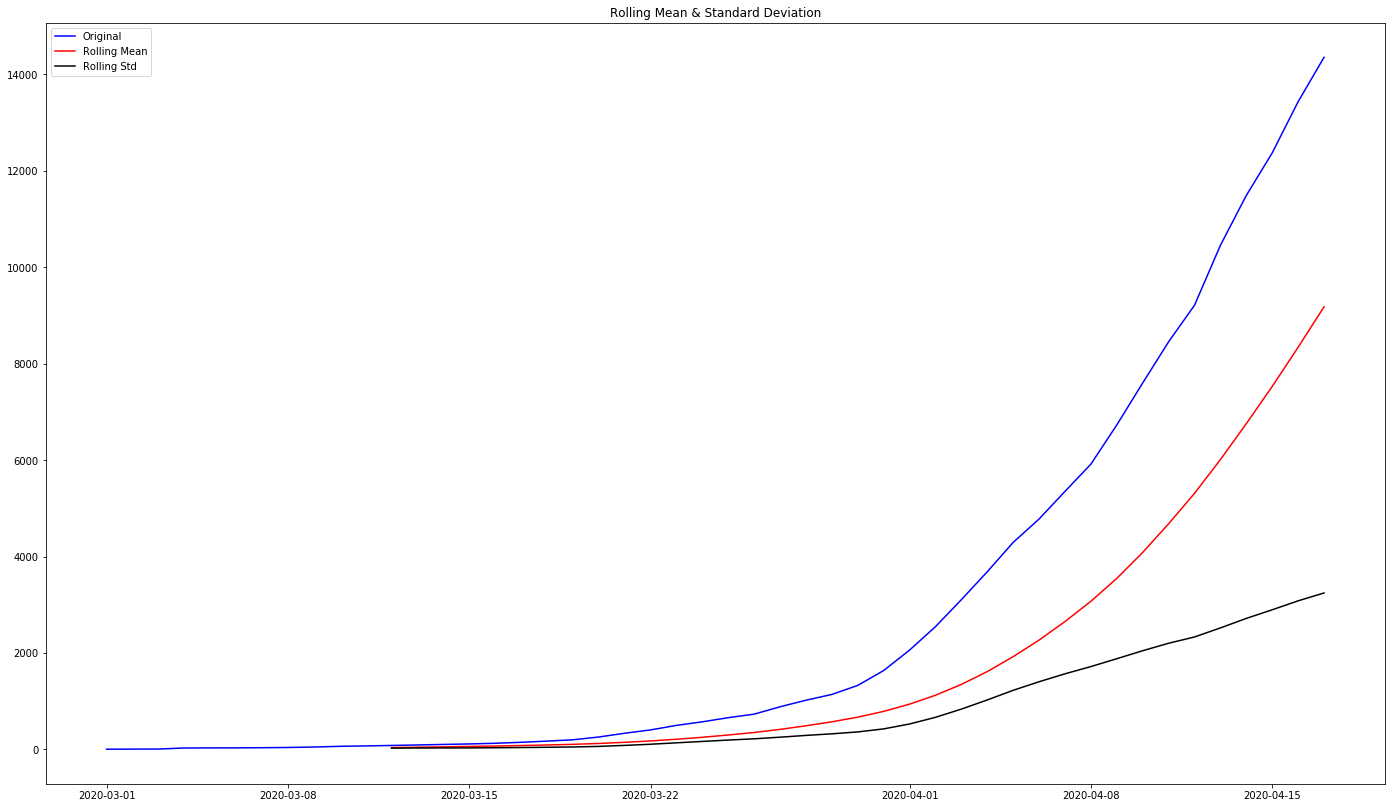

In [13]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [15]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['Total Confirmed'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -1.027335
p-value                         0.743164
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


#### Log Scale Transformation ¶


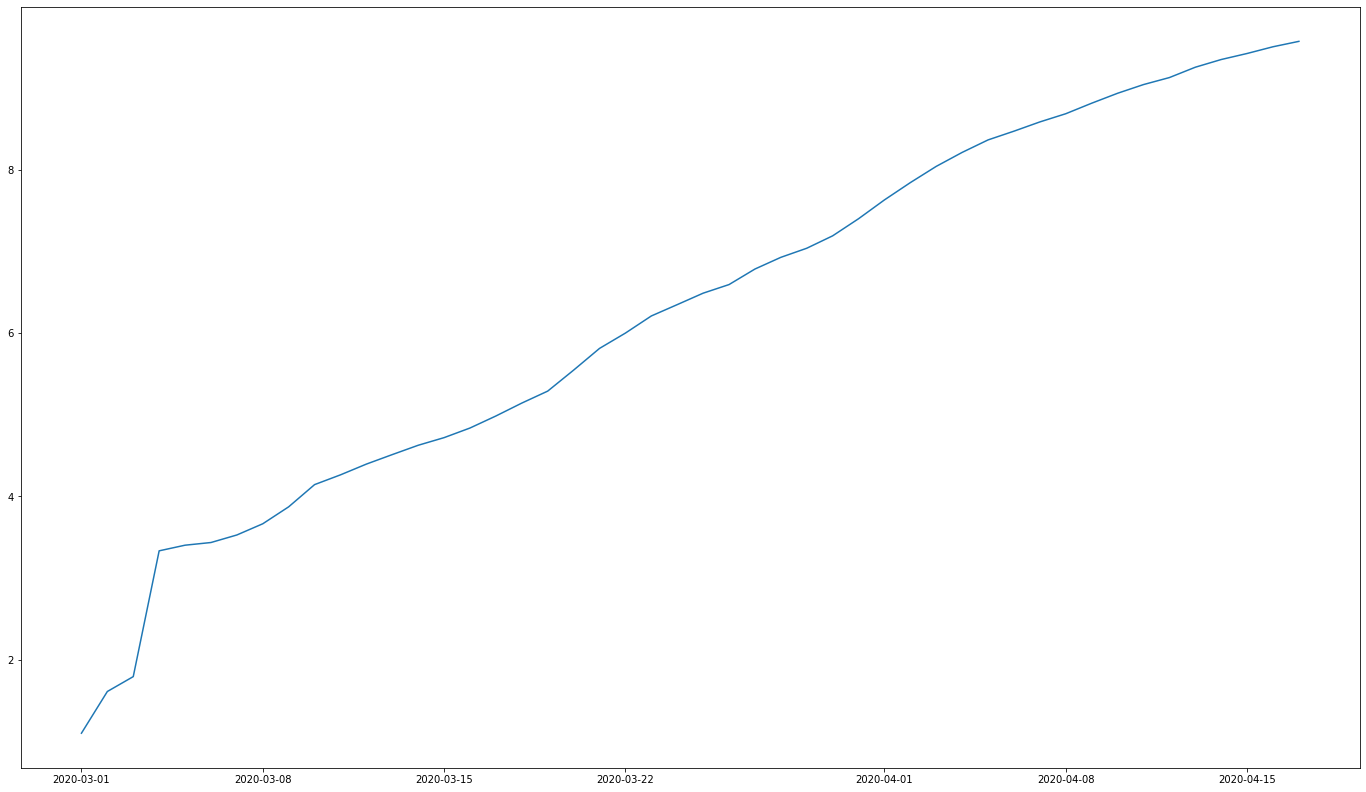

In [16]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

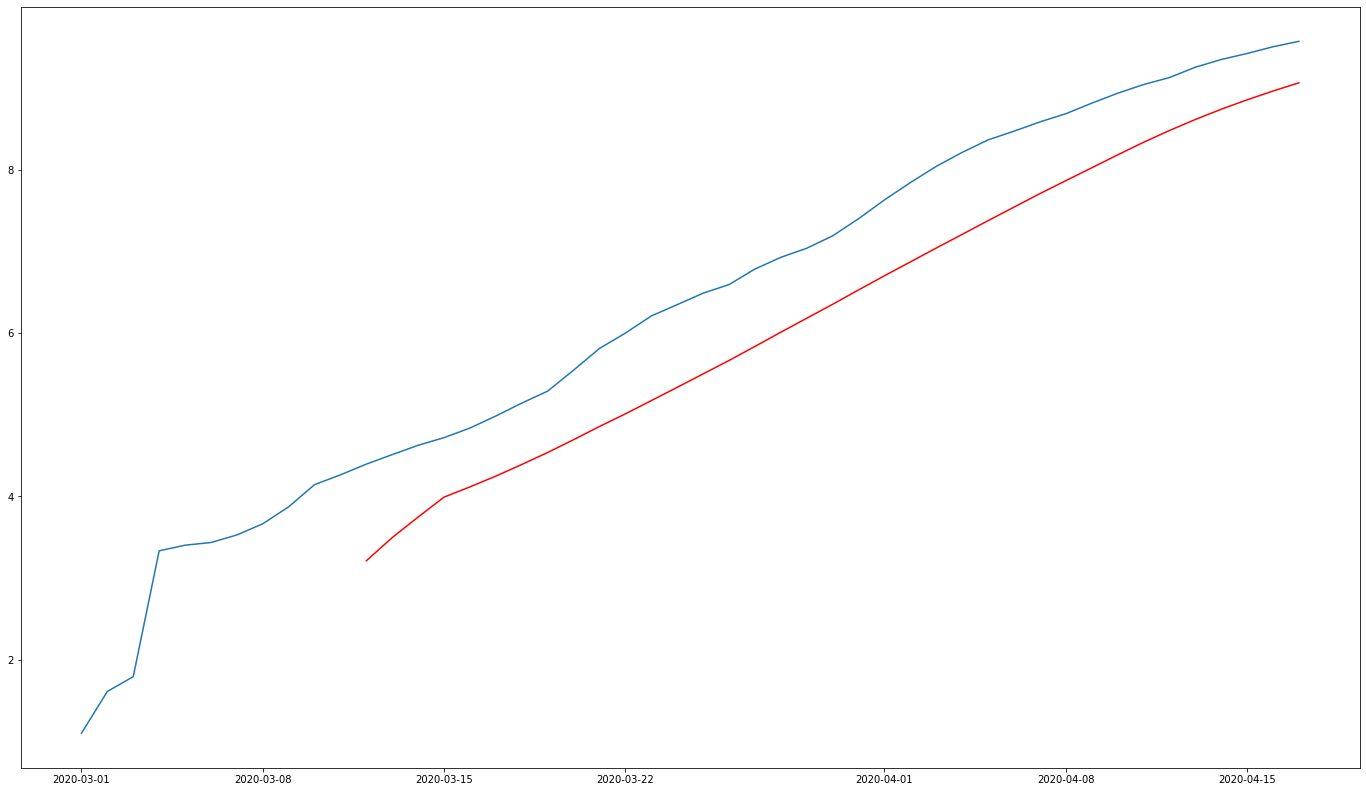

In [17]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [18]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Total Confirmed
date_format,
2020-03-12,1.183734
2020-03-13,1.015790
2020-03-14,0.878609
2020-03-15,0.728240
2020-03-16,0.720683
2020-03-17,0.736140
2020-03-18,0.751891
2020-03-19,0.751669
2020-03-20,0.851778


In [19]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Total Confirmed'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

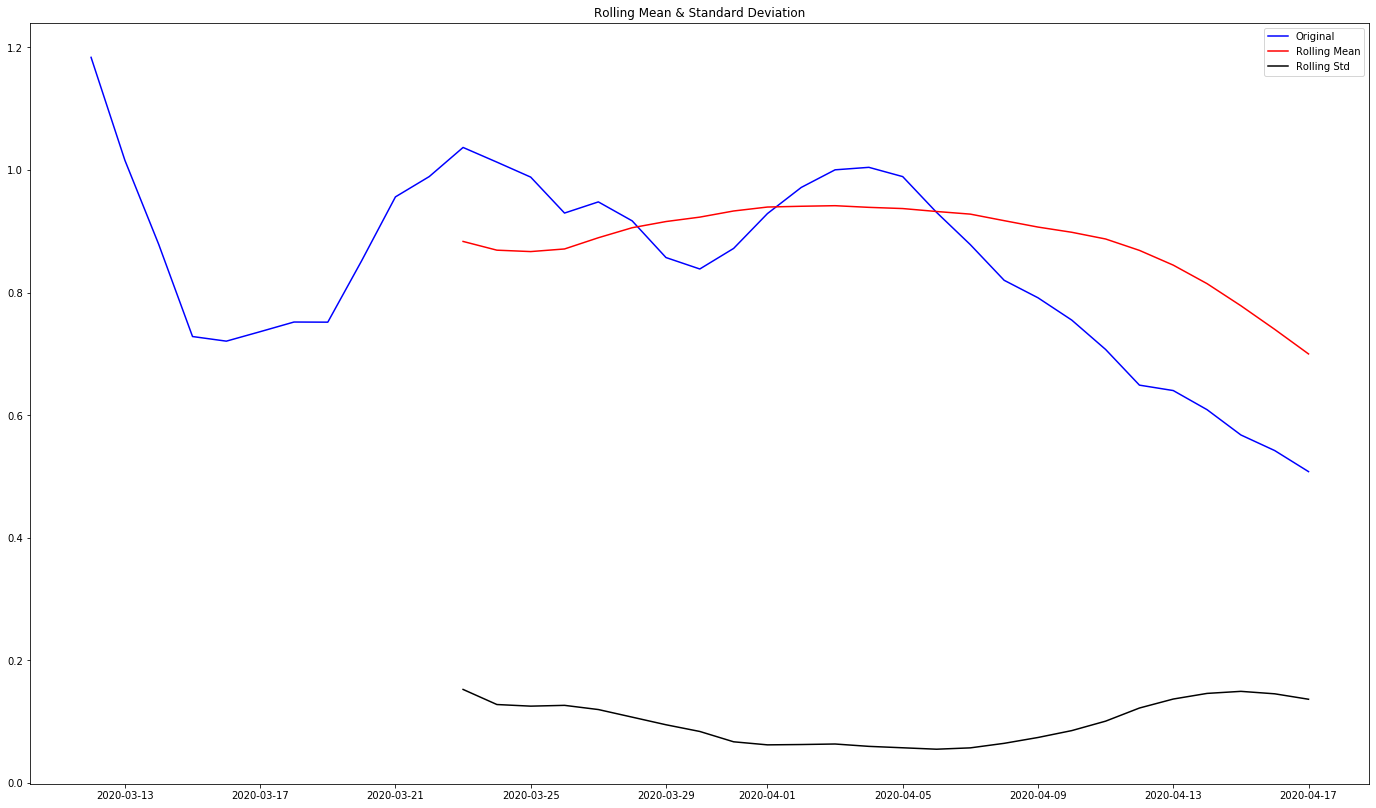

Results of Dickey Fuller Test:
Test Statistic                 -1.479895
p-value                         0.543432
#Lags Used                      1.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [20]:
test_stationarity(datasetLogScaleMinusMovingAverage)


#### Exponential Decay Transformation ¶


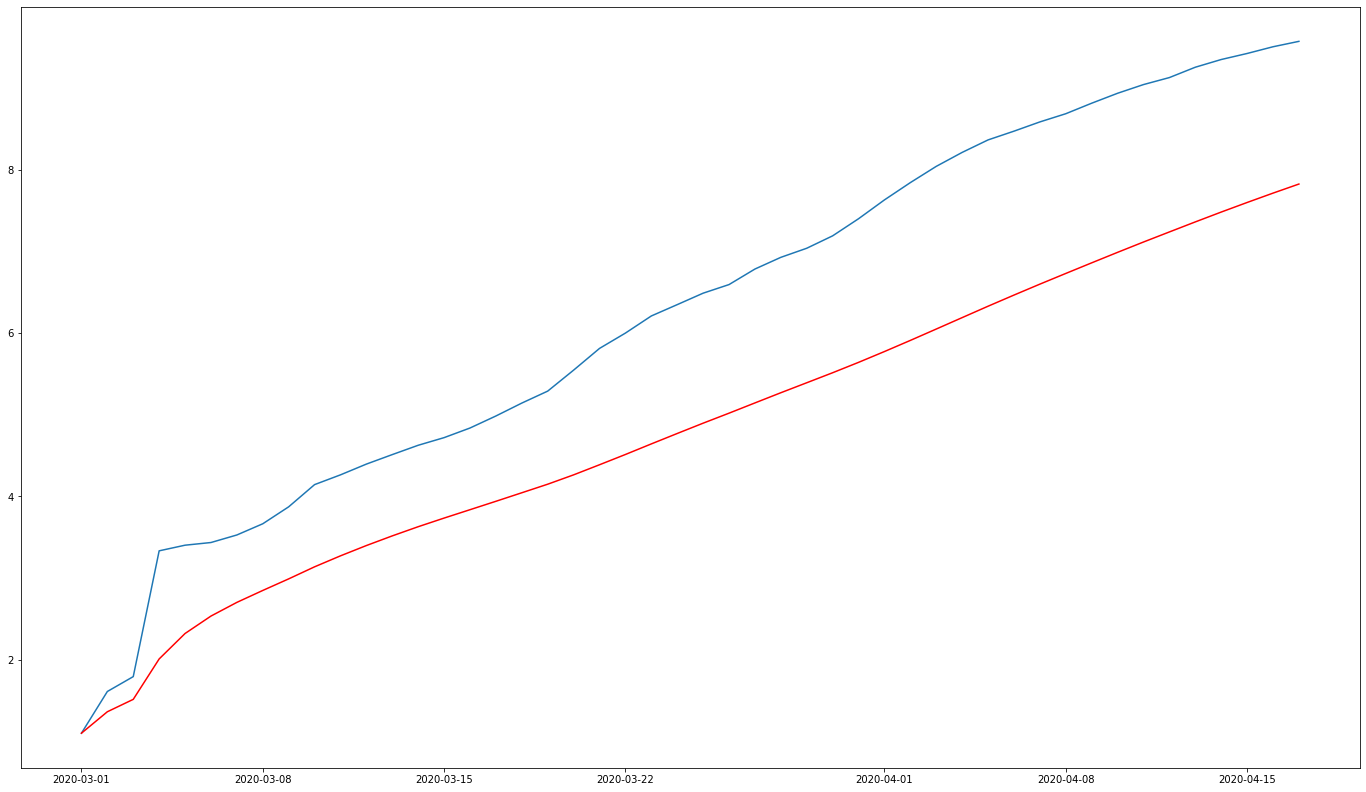

In [21]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

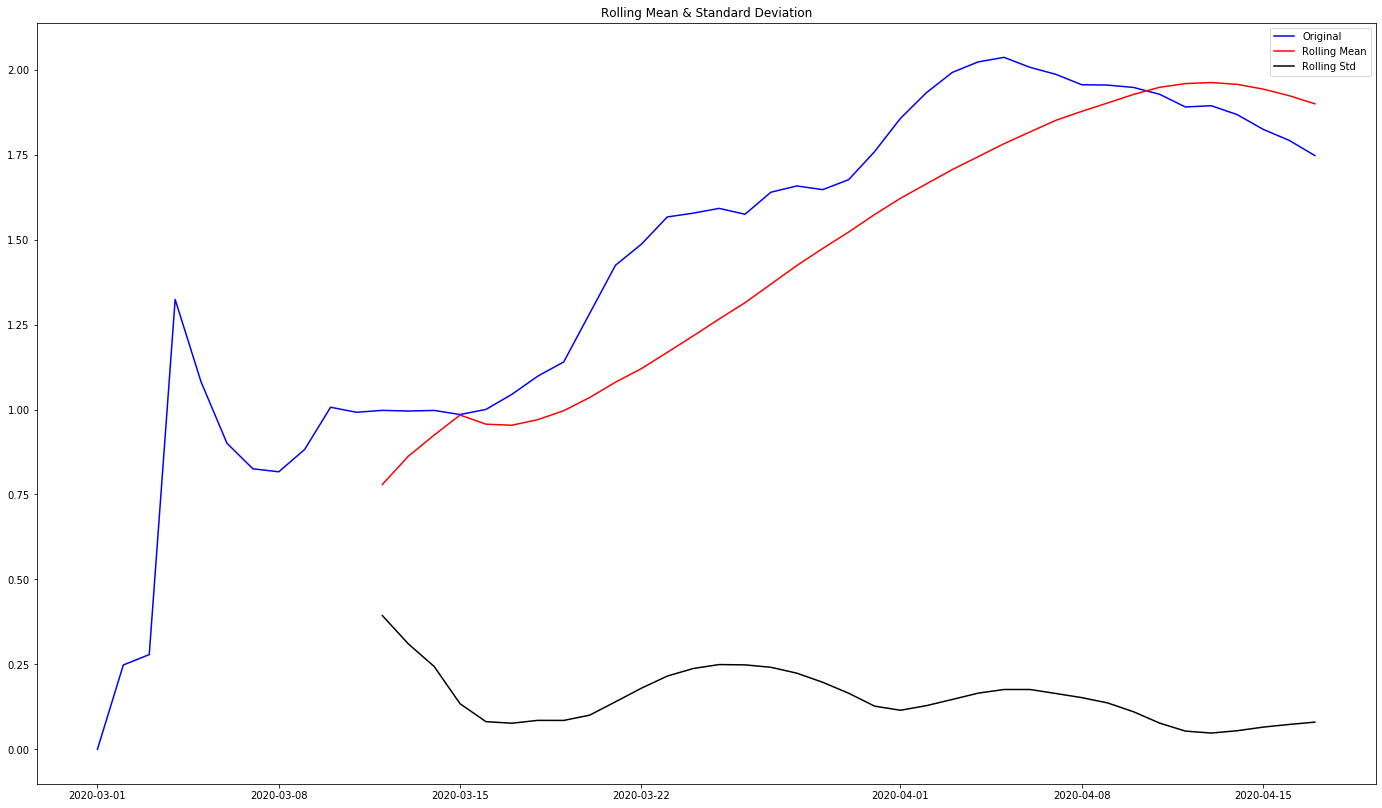

Results of Dickey Fuller Test:
Test Statistic                 -2.677021
p-value                         0.078100
#Lags Used                      1.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


In [22]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

#### Time Shift Transformation

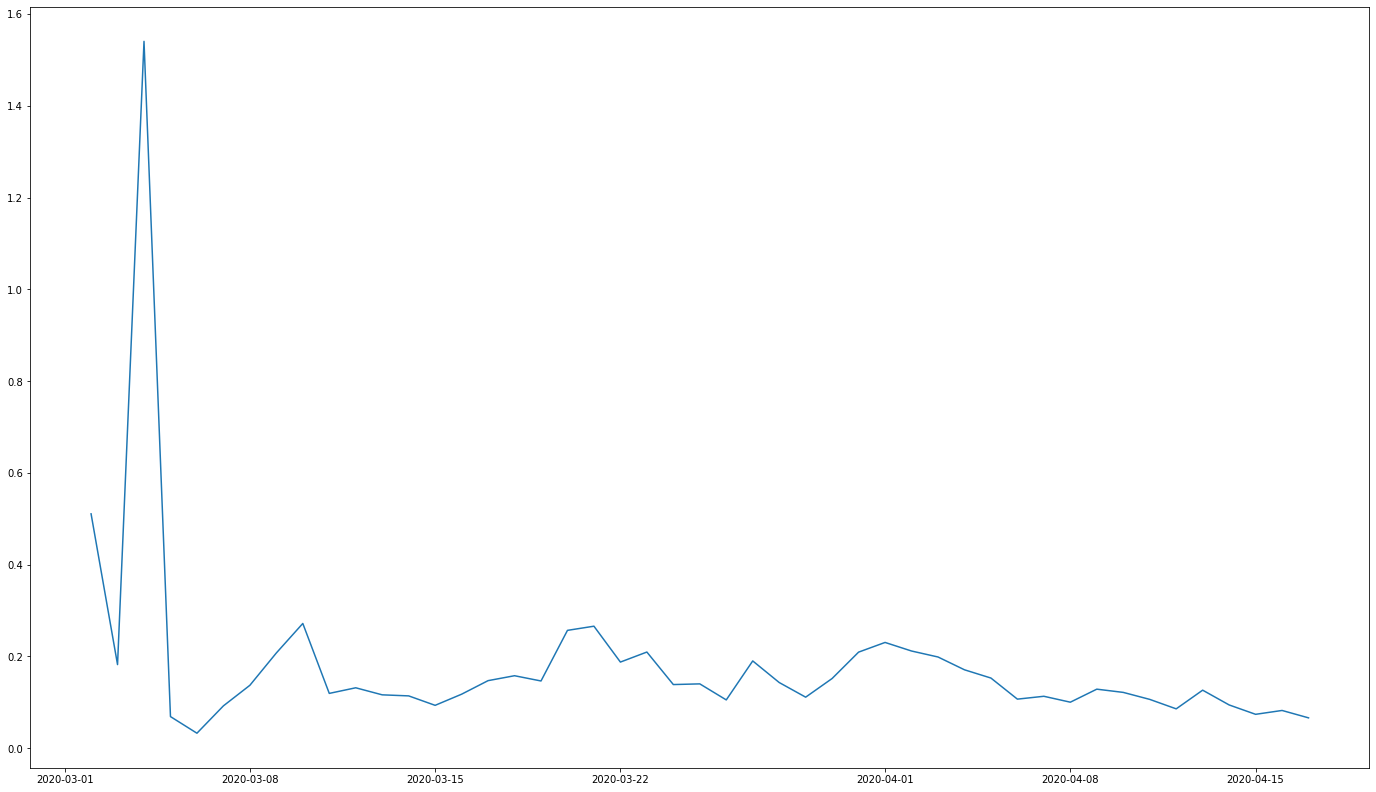

In [23]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

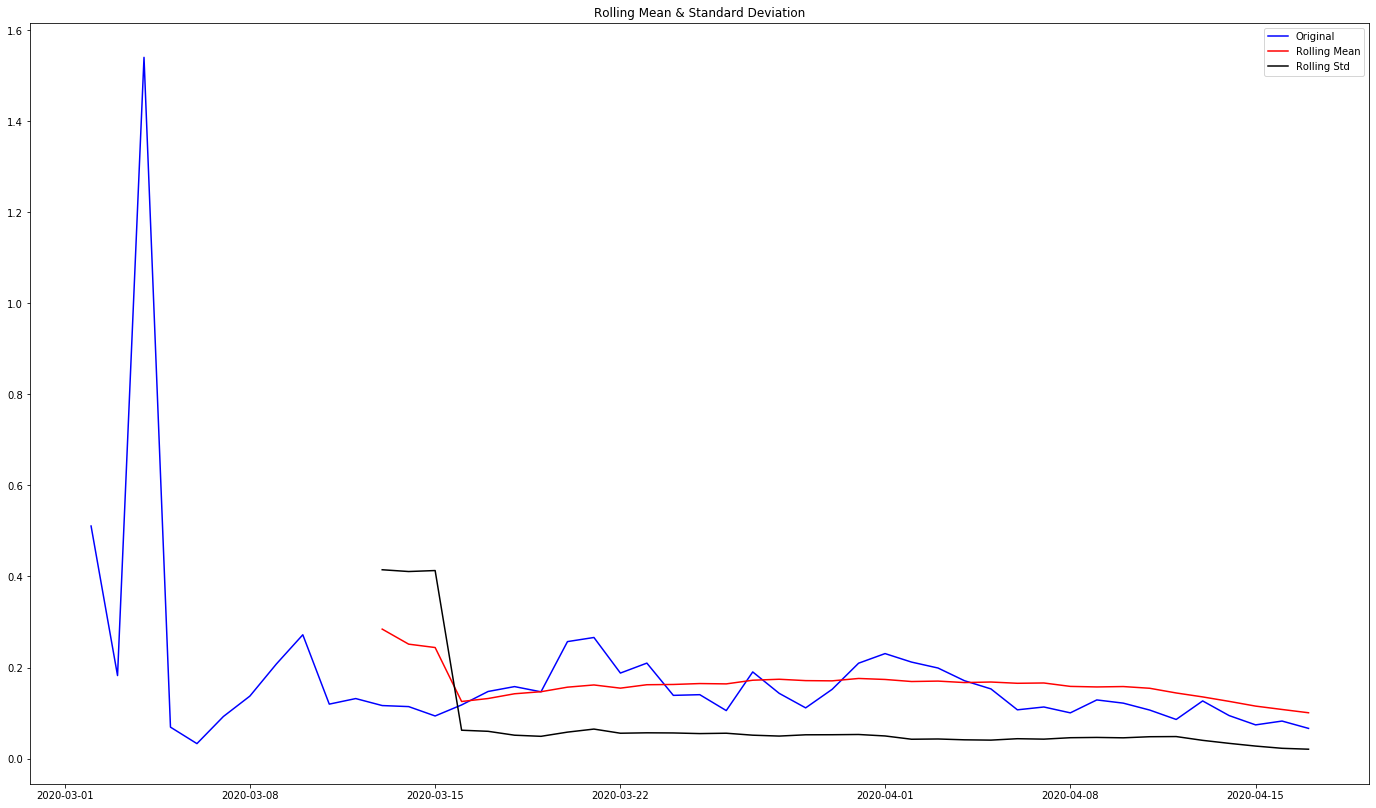

Results of Dickey Fuller Test:
Test Statistic                -6.814777e+00
p-value                        2.072520e-09
#Lags Used                     0.000000e+00
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
dtype: float64


In [24]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

#### Residual
The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values.<br>


Residuals are useful in checking whether a model has adequately captured the information in the data

/Users/satyamgovila/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/Users/satyamgovila/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


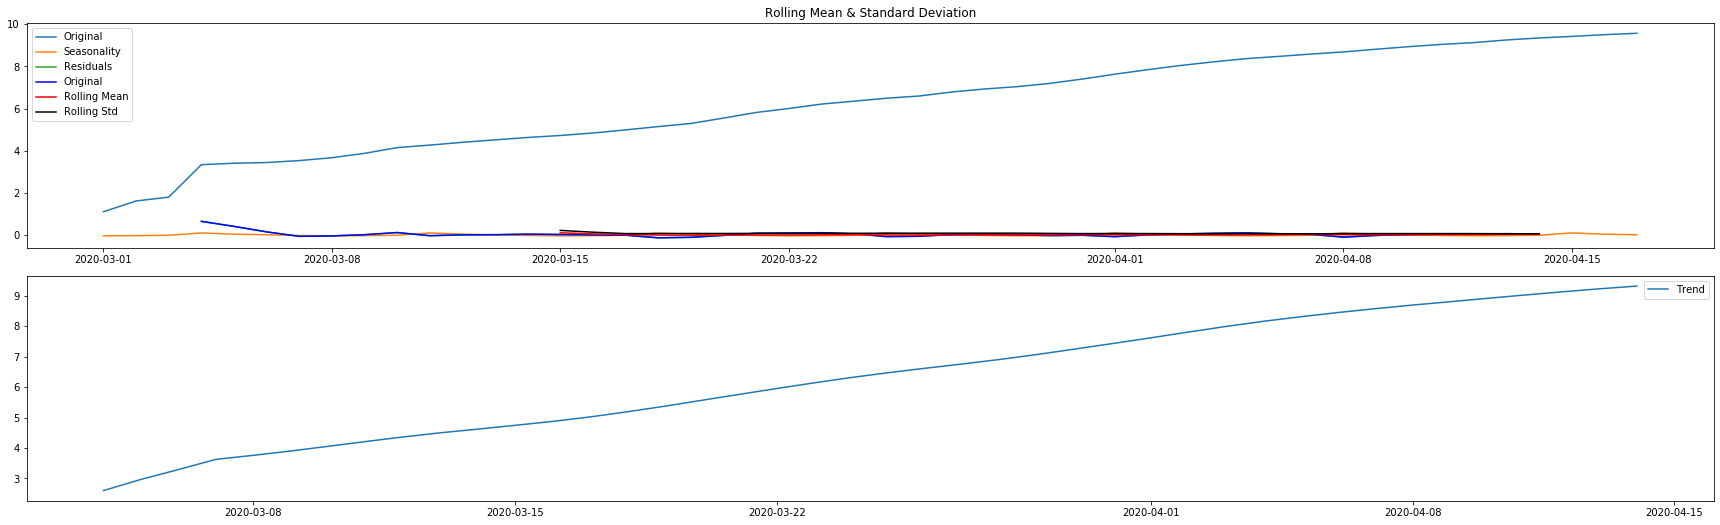

Results of Dickey Fuller Test:
Test Statistic                 -2.806828
p-value                         0.057305
#Lags Used                     10.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [25]:
decomposition = seasonal_decompose(indexedDataset_logScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

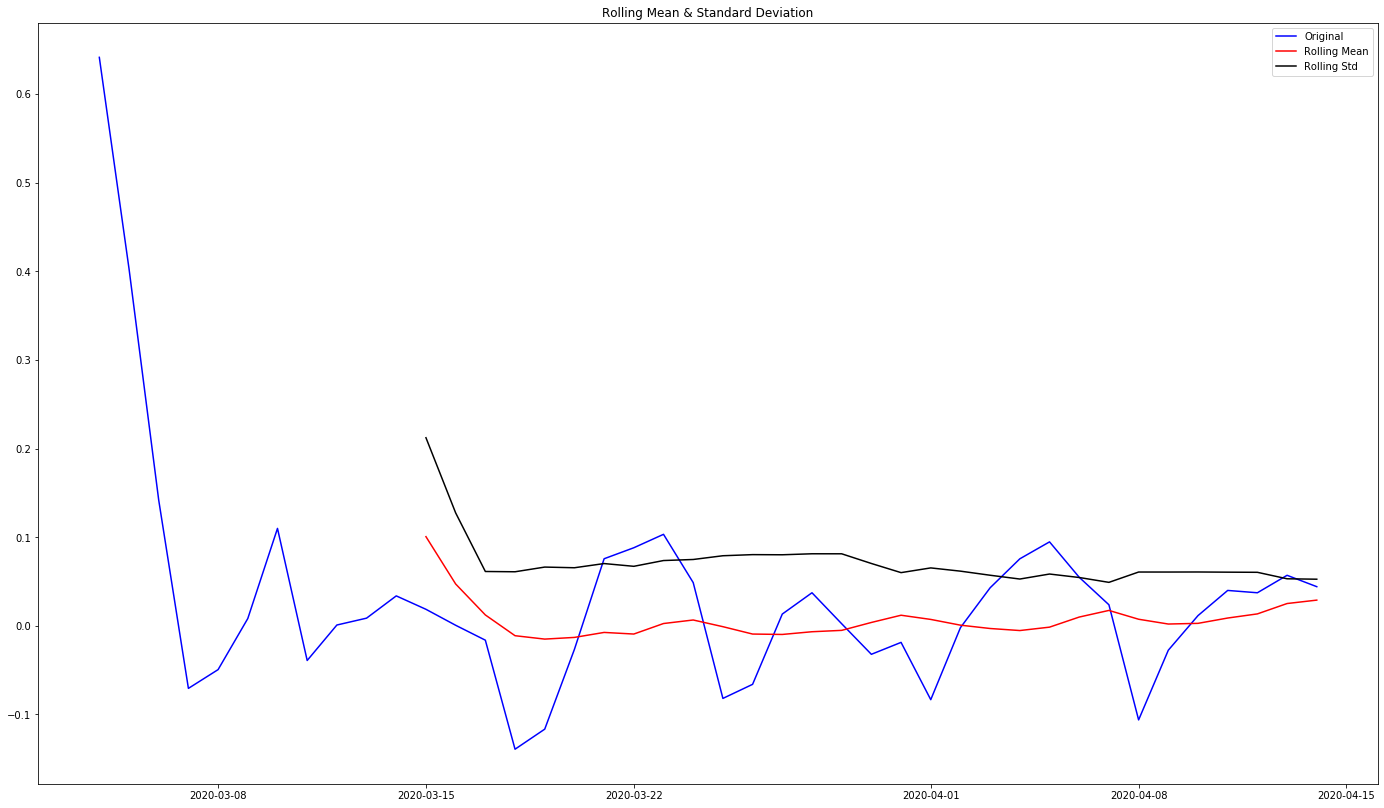

Results of Dickey Fuller Test:
Test Statistic                 -2.806828
p-value                         0.057305
#Lags Used                     10.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [26]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

#### Auto and Partial Correlation Function
We need to take help of ACF(Auto Correlation Function) & PACF(Partial Auto Correlation Function) plots. <br>ACF & PACF graphs are used to find value of P & Q for ARIMA. We need to check, for which value in x-axis, graph line drops to 0 in y-axis for 1st time.
From PACF(at y=0), get P
From ACF(at y=0), get Q

/Users/satyamgovila/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


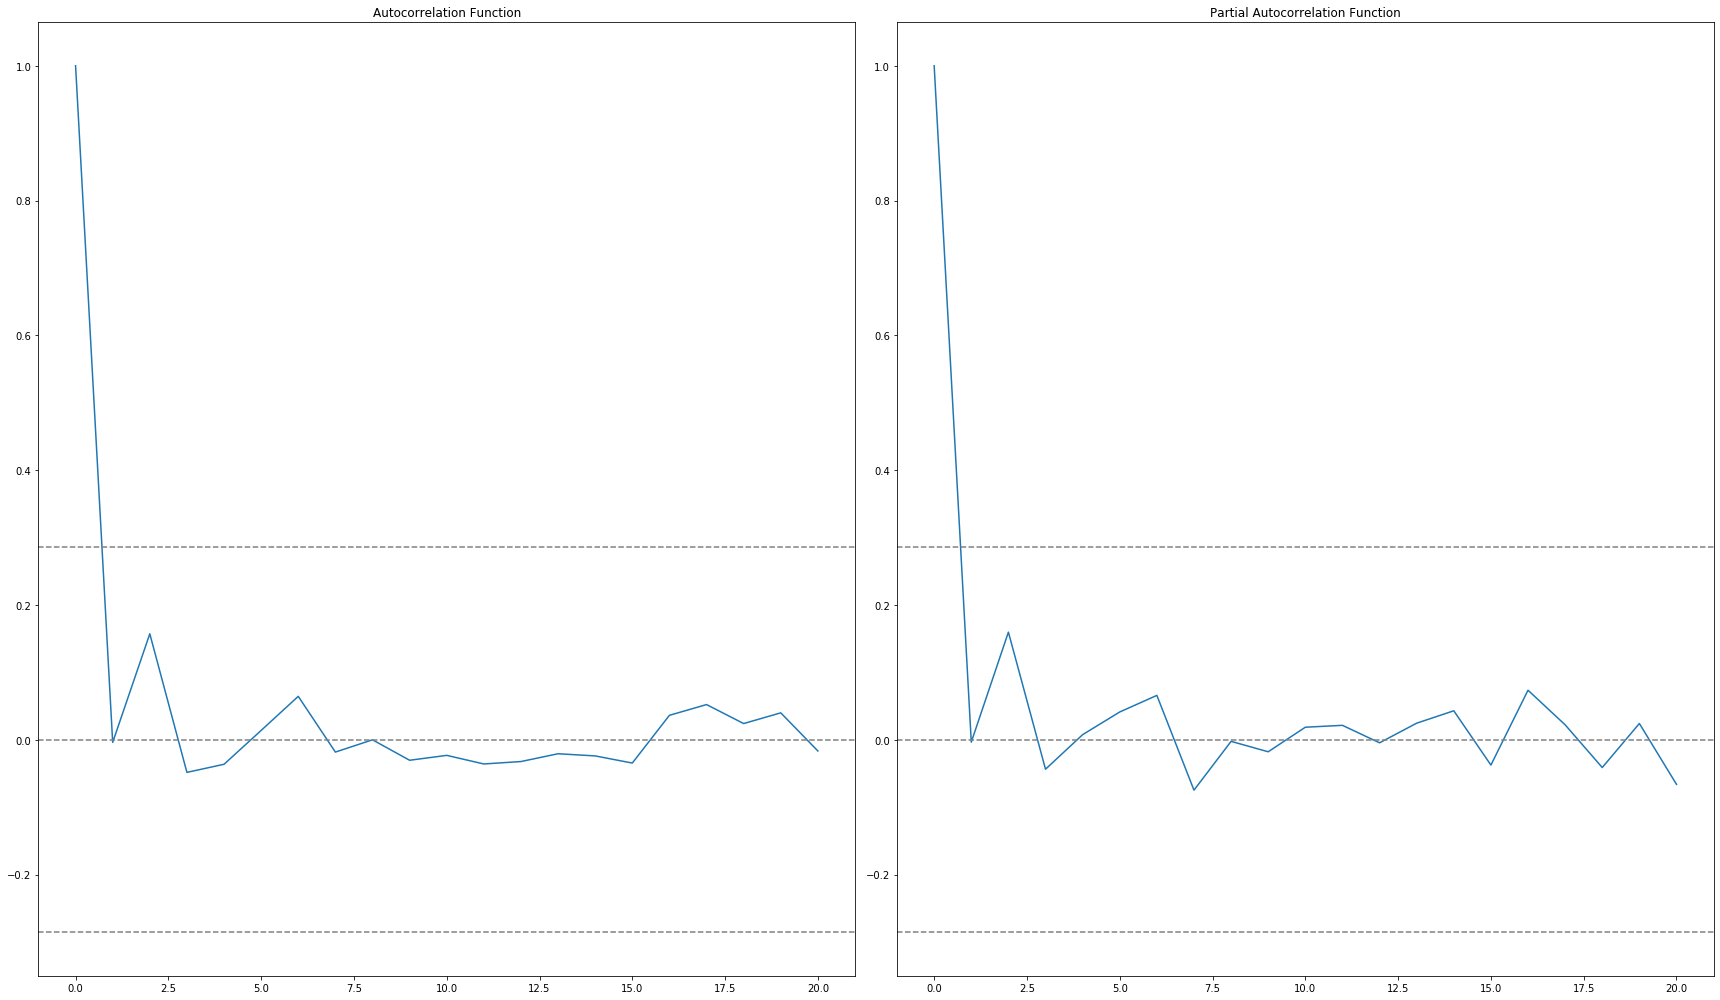

In [28]:
#ACF & PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2 From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. <br>These models will give a value of RSS. Lower RSS values indicate a better model.

### Building Models 

/Users/satyamgovila/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/satyamgovila/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Plotting AR model


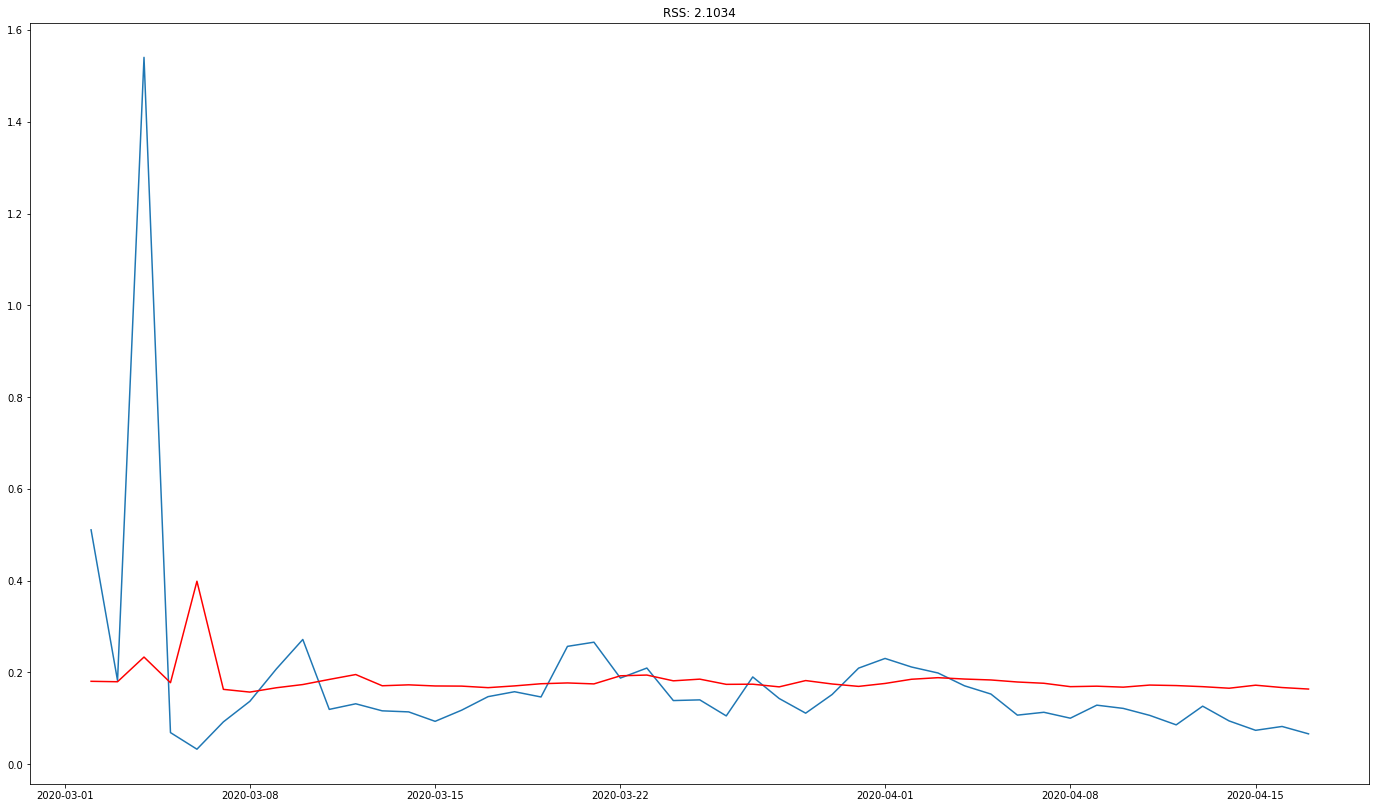

In [71]:

model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Total Confirmed'])**2))
print('Plotting AR model')


### Prediction & Reverse transformations ¶


In [72]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date_format
2020-03-02    0.180748
2020-03-03    0.179803
2020-03-04    0.233622
2020-03-05    0.177731
2020-03-06    0.398839
dtype: float64


In [73]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

date_format
2020-03-02    0.180748
2020-03-03    0.360551
2020-03-04    0.594173
2020-03-05    0.771904
2020-03-06    1.170743
2020-03-07    1.333943
2020-03-08    1.491201
2020-03-09    1.657896
2020-03-10    1.831603
2020-03-11    2.016439
2020-03-12    2.211942
2020-03-13    2.383003
2020-03-14    2.556059
2020-03-15    2.726660
2020-03-16    2.896943
2020-03-17    3.063869
2020-03-18    3.234610
2020-03-19    3.410058
2020-03-20    3.587253
2020-03-21    3.762348
2020-03-22    3.955092
2020-03-23    4.149474
2020-03-24    4.331281
2020-03-25    4.516761
2020-03-26    4.690885
2020-03-27    4.865334
2020-03-28    5.033982
2020-03-29    5.216347
2020-03-30    5.391255
2020-03-31    5.560950
2020-04-01    5.737026
2020-04-02    5.922257
2020-04-03    6.110912
2020-04-04    6.296608
2020-04-05    6.480285
2020-04-06    6.659535
2020-04-07    6.836013
2020-04-08    7.005115
2020-04-09    7.175244
2020-04-10    7.343242
2020-04-11    7.515804
2020-04-12    7.687274
2020-04-13    7.856354

In [74]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Total Confirmed'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

date_format
2020-03-01    1.098612
2020-03-02    1.279360
2020-03-03    1.459163
2020-03-04    1.692785
2020-03-05    1.870516
dtype: float64

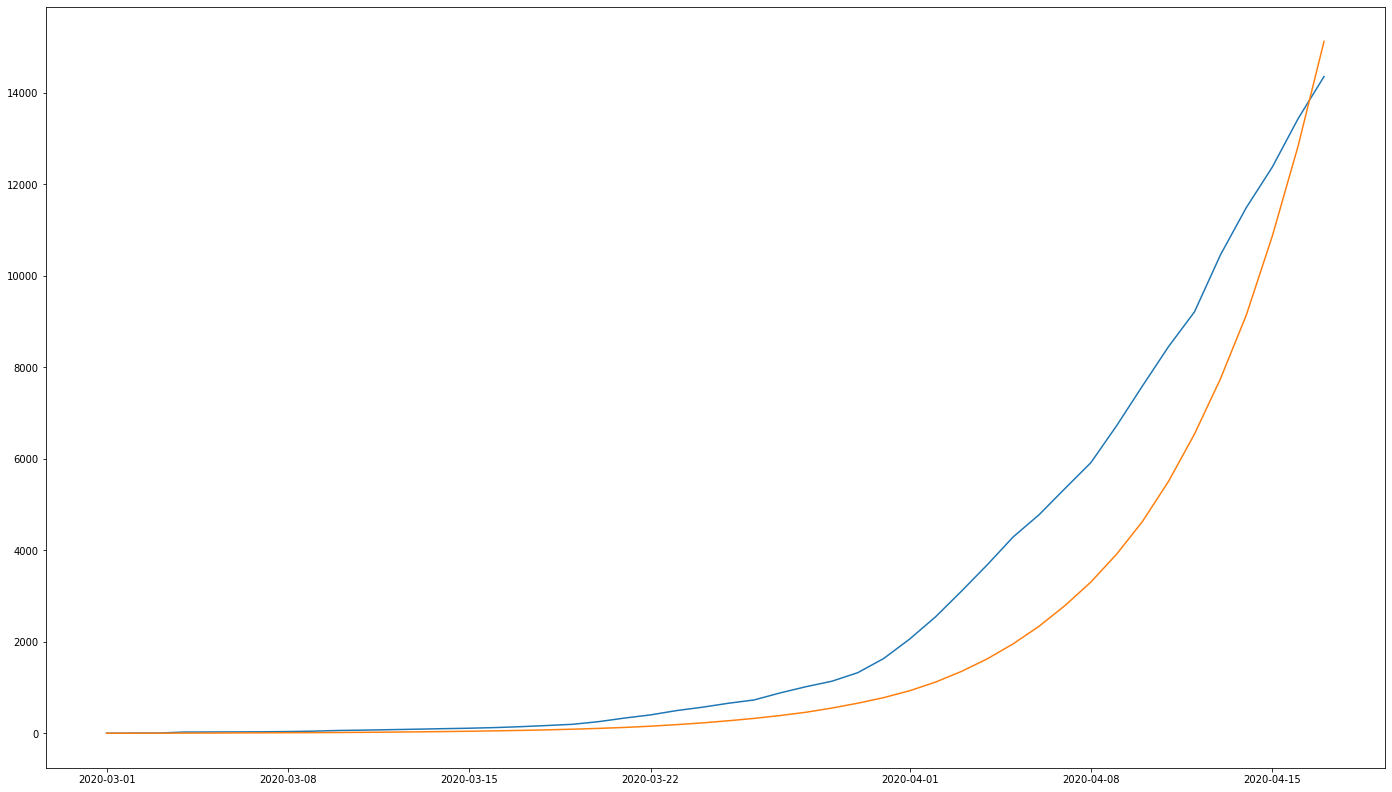

In [75]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [77]:
indexedDataset_logScale.shape


(48, 1)

In [78]:
48+14

62

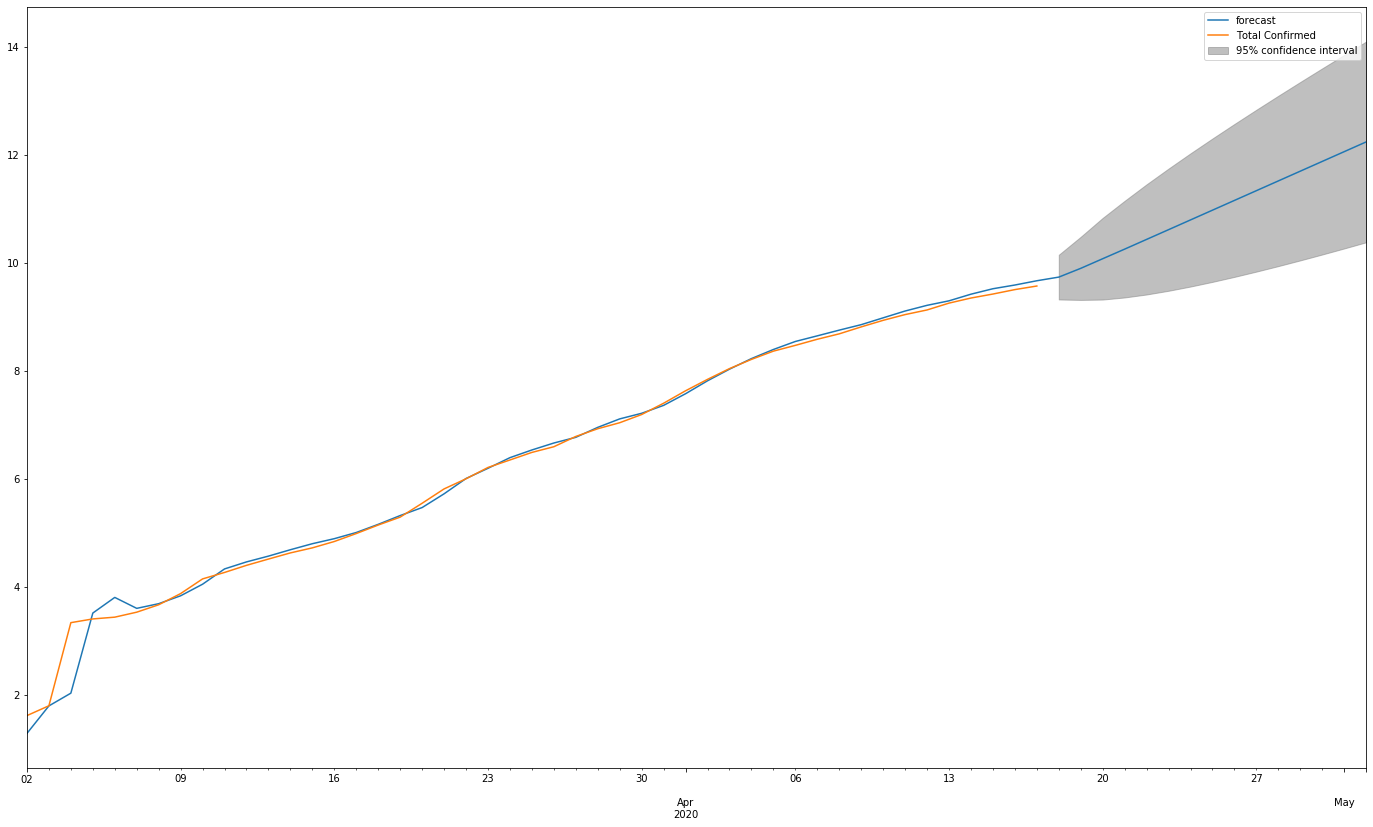

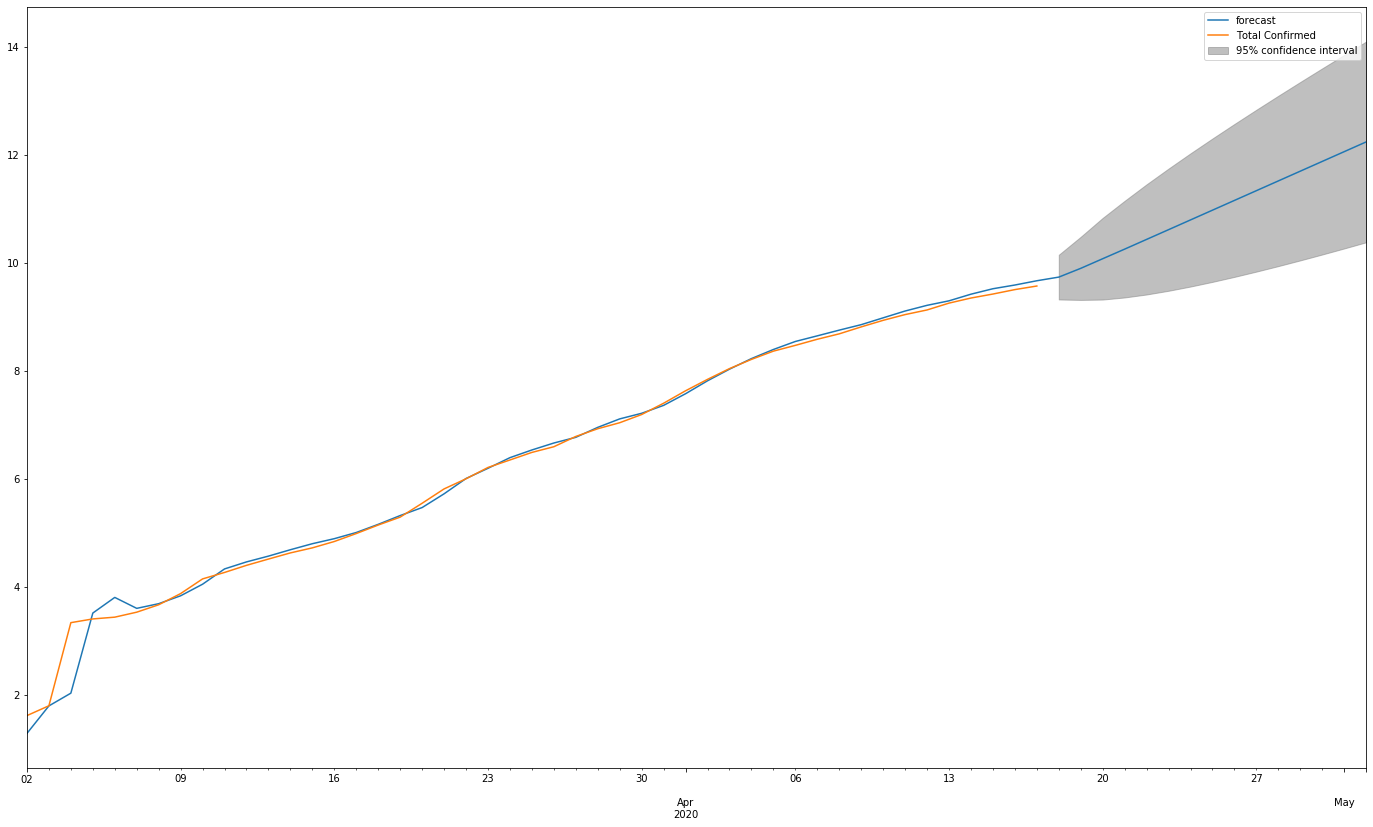

In [79]:
results_ARIMA.plot_predict(1,62) 


In [80]:
forecast, stderr, conf = results_ARIMA.forecast()
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Prediction Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Forecast: 9.737
Standard Error: 0.211
95% Prediction Interval: 9.323 to 10.151
